In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=cf8fc794656be3b789b5167ebb7104cc5083e4a133d375ad0f07e533135d4d9f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.2 MB/s eta 0:00:00


In [3]:
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   3317      0 --:--:-- --:--:-- --:--:--  3346
100   146  100   146    0     0    445      0 --:--:-- --:--:-- --:--:--   445
curl: (23) Failure writing output to destination


In [4]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [5]:
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

In [6]:
import random
from graphframes import GraphFrame
from pyspark.sql import SparkSession

# Generate random city names
city_names = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose", "Austin", "Jacksonville", "San Francisco", "Indianapolis", "Seattle"]

# Generate random coordinates for cities
cities = []
for i, name in enumerate(city_names):
    cities.append((str(i + 1), name, random.uniform(0, 100), random.uniform(0, 100)))

# Define DataFrame for vertices with city names, coordinates, and cost
spark = SparkSession.builder.master("local[*]").appName("Graph").getOrCreate()
vertices = spark.createDataFrame(cities, ["id", "name", "x", "y"])

# Define a cost function for vertices (random in this example)
def cost_function():
    return random.randint(1, 10)

# Add cost column to vertices DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

cost_udf = udf(cost_function, IntegerType())
vertices = vertices.withColumn("cost", cost_udf())

# Define DataFrame for edges with distances between cities
edges = []
for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        distance = ((cities[i][2] - cities[j][2]) ** 2 + (cities[i][3] - cities[j][3]) ** 2) ** 0.5
        # Introduce randomness in connections by randomly removing some edges
        if random.random() < 0.8:  # Adjust the probability to control the randomness of connections
            edges.append((str(i + 1), str(j + 1), distance))

edges_df = spark.createDataFrame(edges, ["src", "dst", "distance"])

# Create GraphFrame
g = GraphFrame(vertices, edges_df)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [7]:
g.vertices.show()
g.edges.show()

+---+-------------+------------------+------------------+----+
| id|         name|                 x|                 y|cost|
+---+-------------+------------------+------------------+----+
|  1|     New York|44.609144642488744| 79.34301885528987|   9|
|  2|  Los Angeles| 36.64848217651916|  60.7728870071619|   8|
|  3|      Chicago| 97.92262086797004| 57.28085082720731|  10|
|  4|      Houston| 98.11392154476844| 63.20092359306031|   8|
|  5|      Phoenix| 82.09976169848096|27.654257028067164|   3|
|  6| Philadelphia| 55.85081490079759|25.584577986108126|   1|
|  7|  San Antonio| 20.45502765836614|28.389159861639936|   9|
|  8|    San Diego| 89.40336579448724| 56.72120268455125|   1|
|  9|       Dallas|47.934576280285654|27.722209791763717|   6|
| 10|     San Jose| 68.27534419204825| 51.59312349535933|   3|
| 11|       Austin| 86.02620936107078| 65.07320506012275|   6|
| 12| Jacksonville|  5.08790132532363| 39.92464720254919|   2|
| 13|San Francisco|22.754996499194156| 78.7762693935199

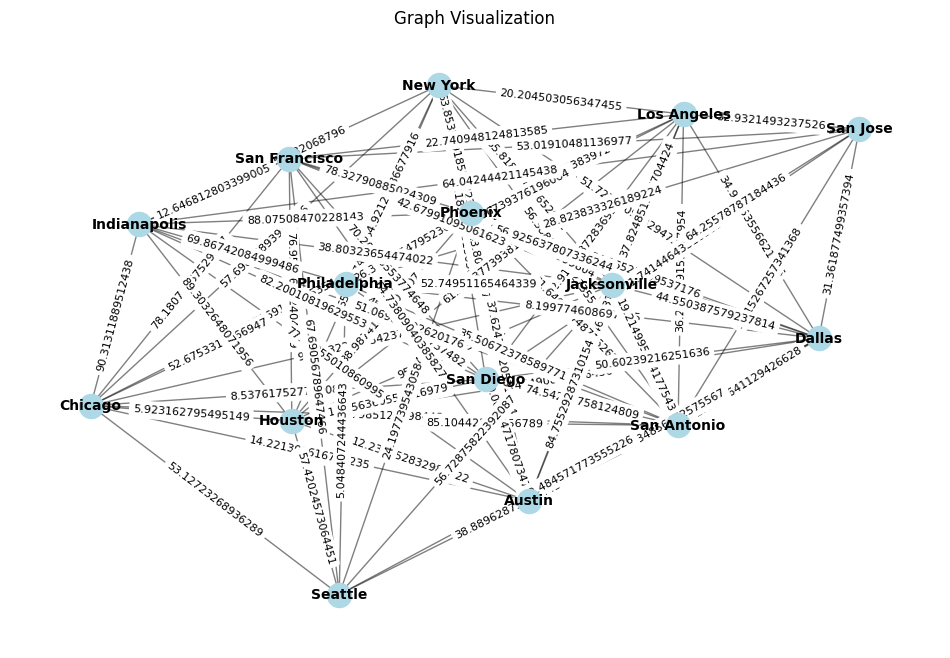

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert vertices and edges DataFrames to pandas DataFrames
vertices_pd = g.vertices.toPandas()
edges_pd = g.edges.toPandas()

# Create a NetworkX graph
G = nx.Graph()

# Add nodes to the graph
for _, row in vertices_pd.iterrows():
    G.add_node(row['id'], name=row['name'], x=row['x'], y=row['y'], cost=row['cost'])

# Add edges to the graph
for _, row in edges_pd.iterrows():
    src_id = row['src']
    dst_id = row['dst']
    src_name = vertices_pd[vertices_pd['id'] == src_id]['name'].iloc[0]
    dst_name = vertices_pd[vertices_pd['id'] == dst_id]['name'].iloc[0]
    G.add_edge(src_id, dst_id, distance=row['distance'], src_name=src_name, dst_name=dst_name)

# Draw the graph
plt.figure(figsize=(12, 8))

# Define positions of nodes
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw node labels
node_labels = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title('Graph Visualization')
plt.axis('off')
plt.show()



In [9]:
# Run PageRank algorithm
results = g.pageRank(resetProbability=0.15, tol=0.01)

# Display the PageRank score for each vertex
results.vertices.show()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+-------------+------------------+------------------+----+-------------------+
| id|         name|                 x|                 y|cost|           pagerank|
+---+-------------+------------------+------------------+----+-------------------+
|  7|  San Antonio| 20.45502765836614|28.389159861639936|   7| 0.7018806087061771|
| 15|      Seattle| 58.71664989936982|  21.4284493227197|   5| 2.0485684669487503|
| 11|       Austin| 86.02620936107078| 65.07320506012275|   6| 0.9062881719945955|
|  3|      Chicago| 97.92262086797004| 57.28085082720731|   8|0.44870184648515965|
|  8|    San Diego| 89.40336579448724| 56.72120268455125|   5| 0.7419361675973929|
|  5|      Phoenix| 82.09976169848096|27.654257028067164|   2| 0.5740459605161874|
|  6| Philadelphia| 55.85081490079759|25.584577986108126|   8| 0.5843586877297959|
|  9|       Dallas|47.934576280285654|27.722209791763717|   6| 0.8881423357364082|
|  1|     New York|44.609144642488744| 79.34301885528987|   8| 0.4165164819693465|
| 10

In [10]:
# Find shortest paths from a source vertex
shortest_paths = g.shortestPaths(landmarks=["1"])
shortest_paths.show()


+---+-------------+------------------+------------------+----+---------+
| id|         name|                 x|                 y|cost|distances|
+---+-------------+------------------+------------------+----+---------+
|  7|  San Antonio| 20.45502765836614|28.389159861639936|   6|       {}|
| 15|      Seattle| 58.71664989936982|  21.4284493227197|   3|       {}|
| 11|       Austin| 86.02620936107078| 65.07320506012275|   1|       {}|
|  3|      Chicago| 97.92262086797004| 57.28085082720731|  10|       {}|
|  8|    San Diego| 89.40336579448724| 56.72120268455125|   3|       {}|
|  5|      Phoenix| 82.09976169848096|27.654257028067164|   5|       {}|
|  6| Philadelphia| 55.85081490079759|25.584577986108126|   2|       {}|
|  9|       Dallas|47.934576280285654|27.722209791763717|   7|       {}|
|  1|     New York|44.609144642488744| 79.34301885528987|   5| {1 -> 0}|
| 10|     San Jose| 68.27534419204825| 51.59312349535933|   6|       {}|
|  4|      Houston| 98.11392154476844| 63.200923593

In [11]:
node_degrees = nx.degree(G)
node_degrees_with_city_names = [(city_names[int(node) - 1], degree) for node, degree in node_degrees]
print("Node Degrees with City Names:", node_degrees_with_city_names)

Node Degrees with City Names: [('New York', 11), ('Los Angeles', 11), ('Chicago', 11), ('Houston', 12), ('Phoenix', 12), ('Philadelphia', 11), ('San Antonio', 12), ('San Diego', 11), ('Dallas', 12), ('San Jose', 8), ('Austin', 10), ('Jacksonville', 13), ('San Francisco', 11), ('Indianapolis', 11), ('Seattle', 8)]


In [12]:
# Compute centrality measures like degree centrality, betweenness centrality, and closeness centrality
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


In [13]:
# Print schema of the vertices DataFrame
print("Vertices Schema:")
vertices.printSchema()

# Print schema of the edges DataFrame
print("\nEdges Schema:")
edges_df.printSchema()


Vertices Schema:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- cost: integer (nullable = true)


Edges Schema:
root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- distance: double (nullable = true)



In [14]:
from collections import deque
import pandas as pd
from pyspark.sql import functions as F  # Importing PySpark SQL functions module

def bfs(graph, start_vertex):
    # Extract the adjacency list from the GraphFrame
    adjacency_list = graph.edges.groupBy("src").agg(F.collect_list("dst").alias("neighbors")).toPandas()
    adjacency_list = dict(zip(adjacency_list["src"], adjacency_list["neighbors"]))

    visited = set()  # Set to keep track of visited vertices
    queue = deque([(start_vertex, 0)])  # Queue for BFS traversal, starting vertex with its depth
    traversal_steps = []  # List to store traversal steps

    while queue:
        vertex, depth = queue.popleft()  # Dequeue a vertex and its depth
        visited.add(vertex)  # Mark the vertex as visited
        traversal_steps.append((vertex, depth))  # Add vertex and its depth to traversal steps

        for neighbor in adjacency_list.get(vertex, []):
            if neighbor not in visited:
                queue.append((neighbor, depth + 1))  # Enqueue neighbor with increased depth

    return traversal_steps

# Perform BFS traversal starting from vertex '1'
bfs_steps = bfs(g, '1')

# Convert traversal steps to DataFrame
bfs_df = pd.DataFrame(bfs_steps, columns=['Vertex', 'Depth'])

# Display the BFS traversal steps
print("BFS Traversal:")
print(bfs_df)


BFS Traversal:
    Vertex  Depth
0        1      0
1        2      1
2        3      1
3        4      1
4        5      1
..     ...    ...
97      15      3
98      15      3
99      15      3
100     15      3
101     15      3

[102 rows x 2 columns]


In [15]:
from collections import deque
import pandas as pd
from pyspark.sql import functions as F  # Importing PySpark SQL functions module

def dfs(graph, start_vertex):
    # Extract the adjacency list from the GraphFrame
    adjacency_list = graph.edges.groupBy("src").agg(F.collect_list("dst").alias("neighbors")).toPandas()
    adjacency_list = dict(zip(adjacency_list["src"], adjacency_list["neighbors"]))

    visited = set()  # Set to keep track of visited vertices
    stack = [(start_vertex, 0)]  # Stack for DFS traversal, starting vertex with its depth
    traversal_steps = []  # List to store traversal steps

    while stack:
        vertex, depth = stack.pop()  # Pop a vertex and its depth from the stack
        visited.add(vertex)  # Mark the vertex as visited
        traversal_steps.append((vertex, depth))  # Add vertex and its depth to traversal steps

        for neighbor in reversed(adjacency_list.get(vertex, [])):
            if neighbor not in visited:
                stack.append((neighbor, depth + 1))  # Push neighbor with increased depth to the stack

    return traversal_steps

# Perform DFS traversal starting from vertex '1'
dfs_steps = dfs(g, '1')

# Convert traversal steps to DataFrame
dfs_df = pd.DataFrame(dfs_steps, columns=['Vertex', 'Depth'])

# Display the DFS traversal steps
print("DFS Traversal:")
print(dfs_df)


DFS Traversal:
   Vertex  Depth
0       1      0
1       2      1
2       4      2
3       5      3
4       6      4
..    ...    ...
65      8      1
66      9      1
67     11      1
68     12      1
69     14      1

[70 rows x 2 columns]
